In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from document_scan import *


In [2]:
im = cv.imread("./test1.jpg")
im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
im2 = im.copy()
gray = cv.cvtColor(im.copy(), cv.COLOR_RGB2GRAY)


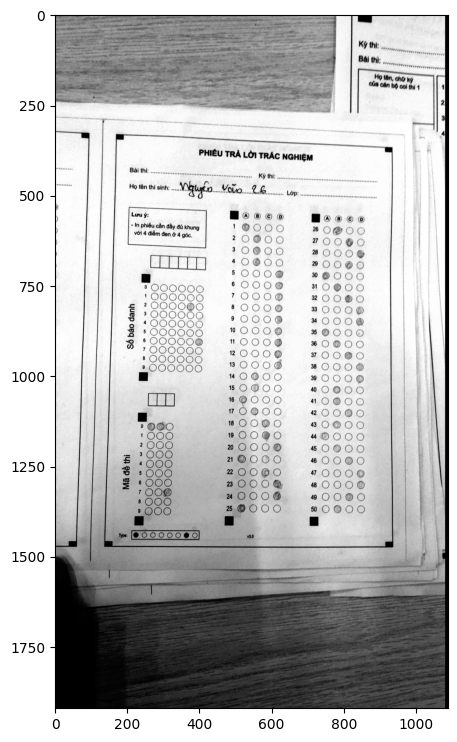

In [3]:
auto_img = auto_brightness_contranst(im)
auto_gray = cv.cvtColor(auto_img.copy(), cv.COLOR_RGB2GRAY)
plotImage(auto_gray)


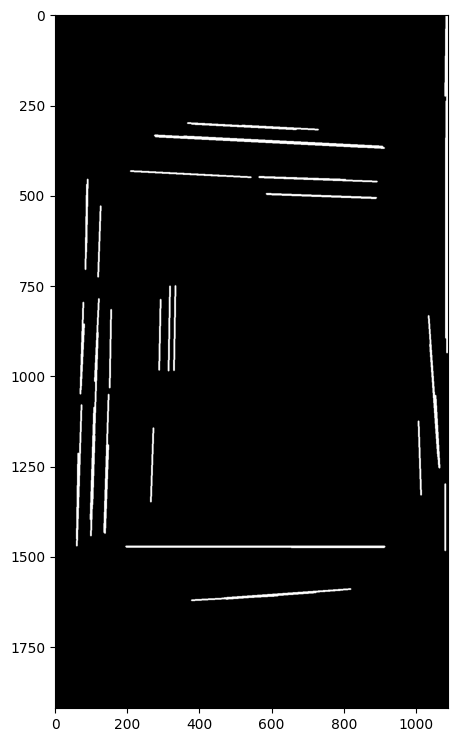

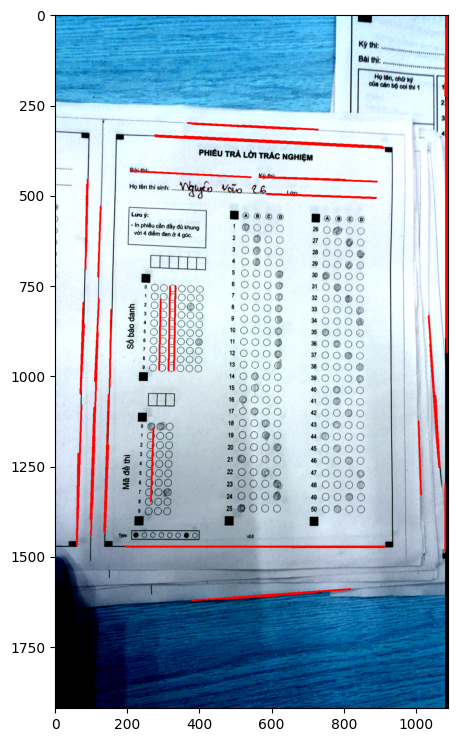

In [4]:

res, original, lines = getFrame(auto_img)
plotImage(res)
plotImage(original)


In [5]:
lenLines = len(lines)
while (True):
    lines = mergeLines(lines, auto_gray)
    if len(lines) == lenLines:
        break
    else:
        lenLines = len(lines)


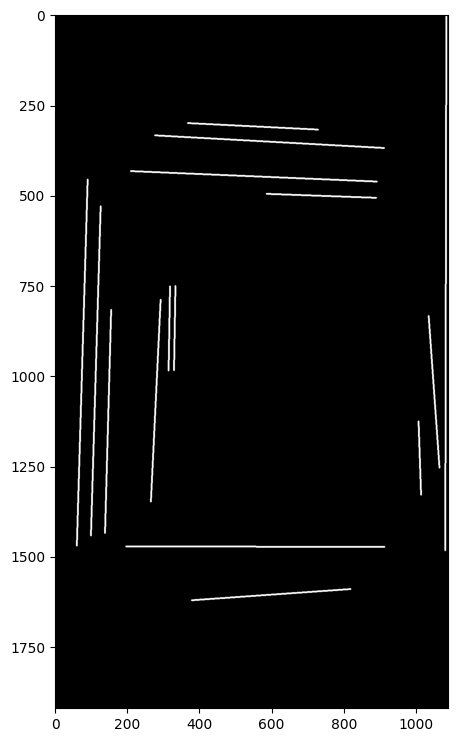

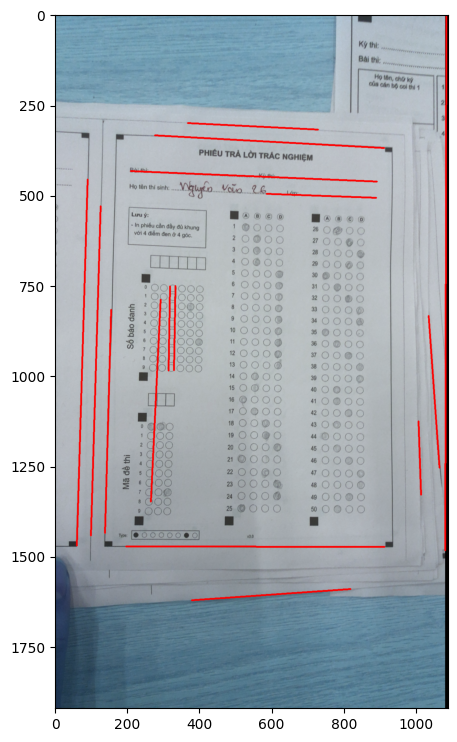

In [6]:
con = np.zeros(im.shape[:2], np.uint8)
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv.line(con, (x1, y1), (x2, y2), 255, 3)
    cv.line(im2, (x1, y1), (x2, y2), 255, 3)
plotImage(con)
plotImage(im2)


In [7]:
def intersection(L1, L2):
    D = L1[0]*L2[1] - L1[1]*L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = Dx / D
        y = Dy / D
        if x < 0 or y < 0:
            return -1, -1
        return int(x), int(y)
    else:
        return -1, -1


In [8]:
def ConnectLine(line, point, maxLenghtConnect, image):
    x1, y1, x2, y2 = line[0]
    x, y = point
    d1 = calDistanceP2P([x1, y1], [x, y])
    d2 = calDistanceP2P([x2, y2], [x, y])
    d = min(d1, d2)
    p = [[x1, y1], [x2, y2], [x, y]]
    p = sorted(p, key=sortPoint)
    if d == d1:
        connectLine = [[x1, y1, x, y]]
    else:
        connectLine = [[x2, y2, x, y]]
    avgLine = checkAvgColorLine(connectLine, image)
    if d <= maxLenghtConnect and avgLine <= 127:
        line = [[p[0][0], p[0][1], p[2][0], p[2][1]]]
        return line
    return line


In [9]:
def calcAvgSectionPoint(point, image, idxRow, idxCol):
    x, y = point
    if idxRow < 0:
        rowLow = y+idxRow
        rowHigh = y
    else:
        rowLow = y
        rowHigh = y+idxRow
    if idxCol < 0:
        colLow = x + idxCol
        colHigh = x
    else:
        colLow = x
        colHigh = x + idxCol
    if rowLow < 0:
        rowLow = 0
    if rowHigh > image.shape[0]:
        rowLow = image.shape[0]
    if colLow < 0:
        colLow = 0
    if colHigh > image.shape[1]:
        colHigh = image.shape[1]
    section = image[rowLow: rowHigh, colLow:colHigh]
    avg = section.mean(axis=0).mean(axis=0)
    return avg


In [10]:
def fillPoint(point, img_gray):
    idxRow = 15
    idxCol = 20
    x, y = point
    midX = int(img_gray.shape[1]/2)
    midY = int(img_gray.shape[0]/2)
    avg1 = calcAvgSectionPoint(point, img_gray, idxRow, idxCol)
    avg2 = calcAvgSectionPoint(point, img_gray, idxRow, -idxCol)
    avg3 = calcAvgSectionPoint(point, img_gray, -idxRow, -idxCol)
    avg4 = calcAvgSectionPoint(point, img_gray, -idxRow, idxCol)
    avgs = [avg1, avg2, avg3, avg4]
    count = 0
    for avg in avgs:
        if avg < 125:
            count += 1
    if count == 0 and count > 1:
        return False
    minavg = min(avg1, avg2, avg3, avg4)

    if minavg < 150:
        if x < midX and y < midY and minavg == avg1:
            return True
        if x >= midX and y < midY and minavg == avg2:
            return True
        if x >= midX and y >= midY and minavg == avg3:
            return True
        if x < midX and y >= midY and minavg == avg4:
            return True
    return False


In [11]:
def findPoint(lines, image):
    points = []
    res_lines = lines
    for i in range(len(lines)):
        for j in range(i+1, len(lines)):
            cosa = calCos(lines[i], lines[j])
            if (np.abs(cosa) <= 0.3):
                L1 = Line(lines[i])
                L2 = Line(lines[j])
                x, y = intersection(L1, L2)
                if [x, y] == [-1, -1]:
                    continue
                elif (x > 0 and x < image.shape[1]) and (y > 0 and y < image.shape[0]):
                    if fillPoint([x, y], image):
                    #if True:
                        res_lines[i] = ConnectLine(
                            res_lines[i], [x, y], 9999, image)
                        res_lines[j] = ConnectLine(
                            res_lines[j], [x, y], 9999, image)
                        points.append([x, y])
    return points, res_lines


In [12]:
points, newLines = findPoint(lines, auto_gray)


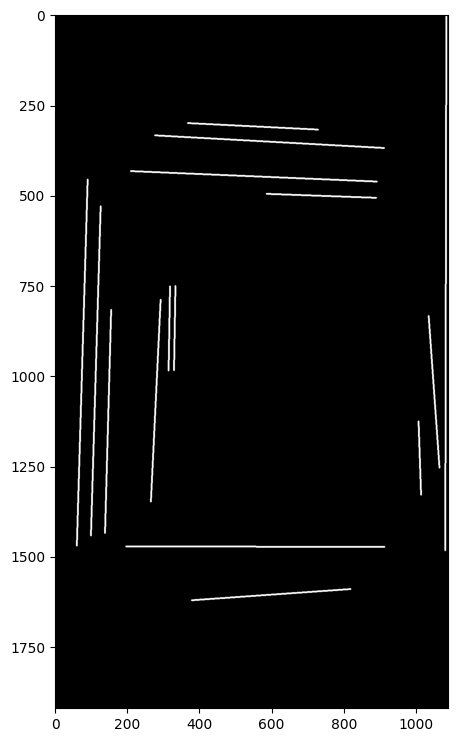

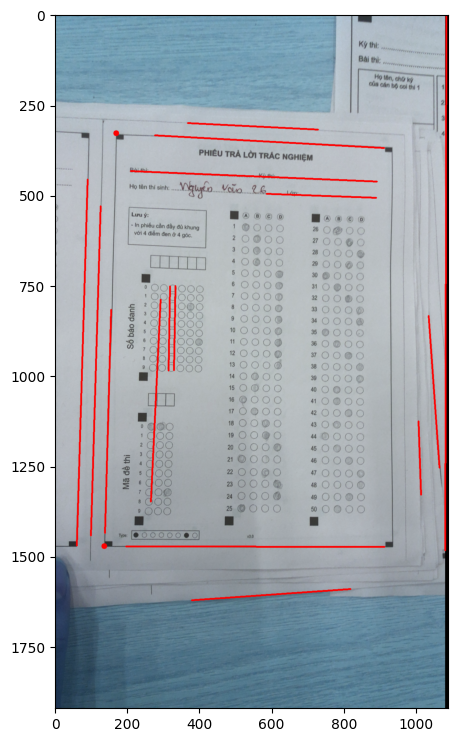

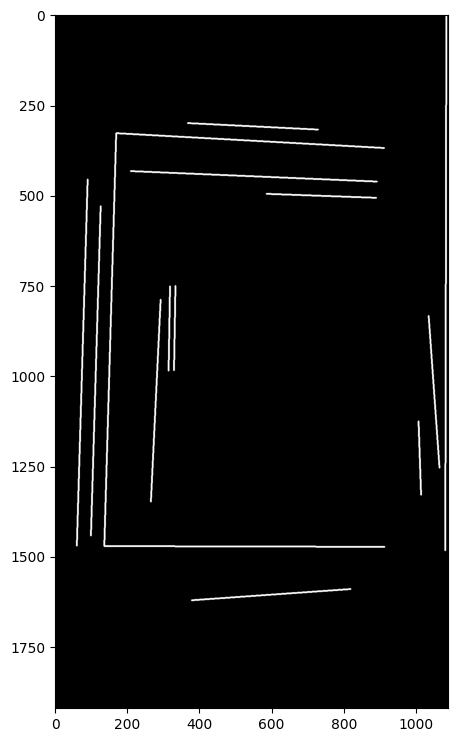

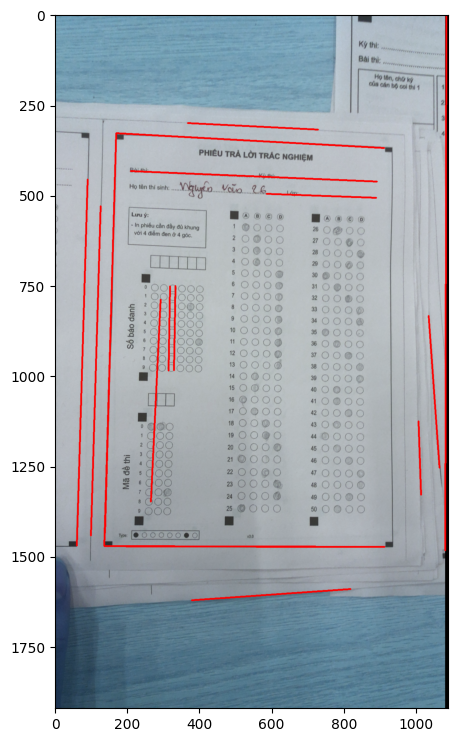

In [13]:
con2 = con.copy()
con3 = np.ones(im.shape[:2], np.uint8)
im3 = im2.copy()
im4 = im2.copy()
for point in points:
    x, y = point
    cv.circle(im3, (x, y), 8, 255, -1)
for line in newLines:
    x1, y1, x2, y2 = line[0]
    cv.line(con3, (x1, y1), (x2, y2), 255, 3)
    cv.line(im4, (x1, y1), (x2, y2), 255, 3)
plotImage(con2)
plotImage(im3)
plotImage(con3)
plotImage(im4)


25


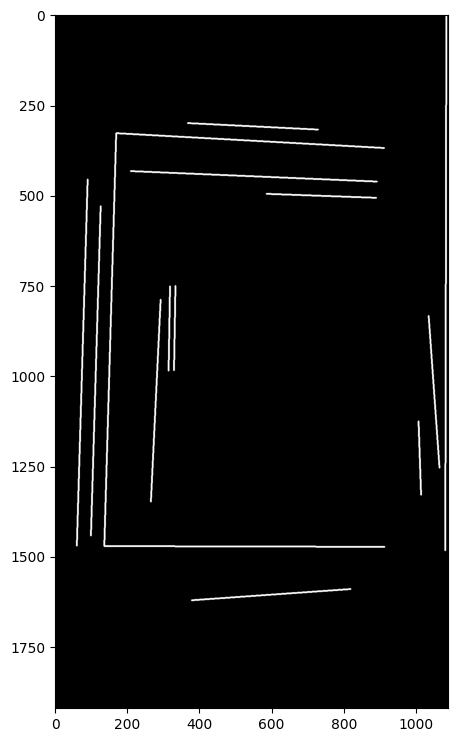

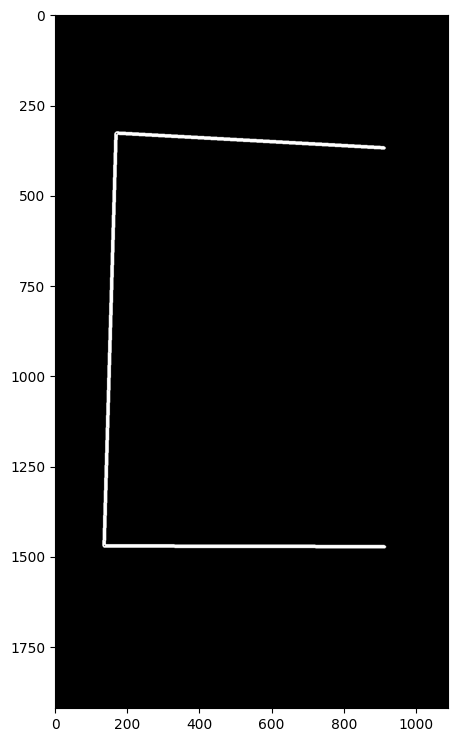

In [14]:
con4 = np.zeros(im.shape[:2], np.uint8)
plotImage(con3)
contest = cv.Canny(con3, 30, 100, apertureSize=3)
contours, _ = cv.findContours(contest, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
print(len(contours))
contours = sorted(contours, key=cv.contourArea, reverse=True)[:1]

cv.drawContours(con4, contours, -1, 255, 3)


plotImage(con4)
